In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

import pandas as pd
import numpy as np
import urllib
import json
import datetime

from utils import plot_series

In [ ]:
!pip install --user kfp --upgrade

In [51]:
train_dataset = pd.read_csv("data/dataset.csv")
eval_dataset = pd.read_csv("data/dataset_eval.csv")

time_train = np.array(train_dataset.times)
x_train = np.array(train_dataset.values)[:,1].astype('float32')

time_eval = np.array(eval_dataset.times)
x_eval = np.array(eval_dataset.values)[:,1].astype('float32')

In [52]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
    Description:  
    Input: 
      - series:
      - window_size:
      - batch_size: the batches to use when training
      -shuffle_buffer: size buffer, how data will be shuffled

    Output:

  """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # x and y (last one)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

window_size = 30
batch_size = 16
shuffle_buffer_size = 100

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

2021-09-12 11:25:17.725621: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-09-12 11:25:17.726923: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b5fdc858a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-12 11:25:17.726969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-12 11:25:17.729526: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


NameError: name 'results' is not defined

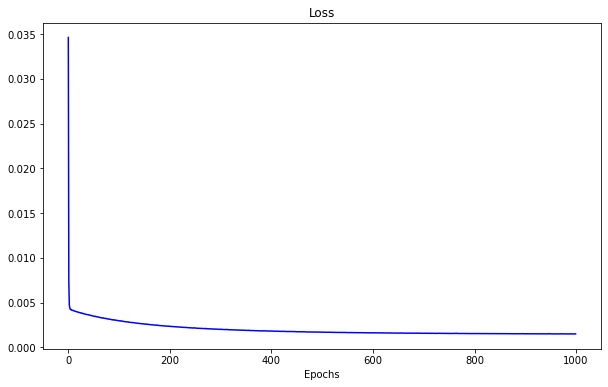

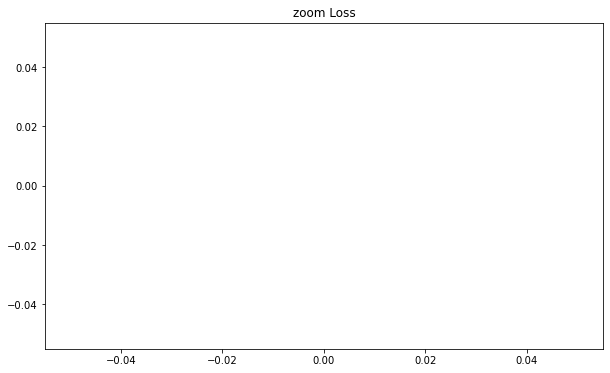

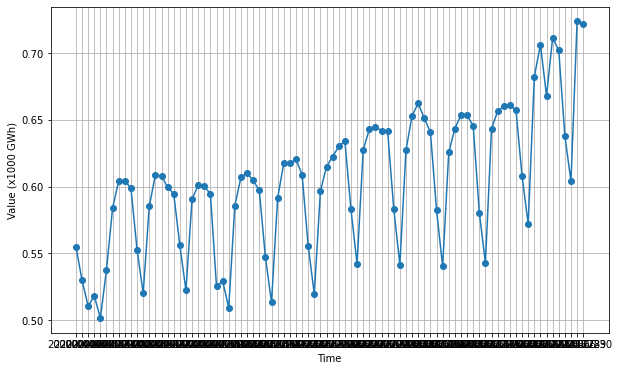

In [53]:
# Dense NN

EPOCHS = 1000
LR = 1e-3

l0 = tf.keras.layers.Dense(2*window_size+1, input_shape=[window_size], activation='relu')
l2 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([l0, l2])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3)

optimizer = tf.keras.optimizers.SGD(lr=LR, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=EPOCHS, verbose=0)

#------------------------------------------------
# Plot Loss
#------------------------------------------------
loss=history.history['loss']
epochs_=range(len(loss)) # Get number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")

n_epochs = 2000
plt.figure(figsize=(10, 6))
plt.plot(epochs_[n_epochs:], loss[n_epochs:], 'b')
plt.title('zoom Loss')


#------------------------------------------------
# Forecasting and evaluation
#------------------------------------------------

eval_dataset = windowed_dataset(x_eval, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
result = np.array(model.predict(eval_dataset))[:, 0]


plt.figure(figsize=(10, 6))
plot_series(time_eval[window_size:], x_eval[window_size:], format='-o')
plot_series(time_eval[window_size:], results, format='-o')

print(tf.keras.metrics.mean_absolute_error(x_eval[window_size:], results).numpy())    

# Using custom containers with AI Platform Training

Objetives: 

1. ¿? how to create a train and a validation split with BigQuery
2. how to wrap a machine learning model into a Docker container and train in on AI Platform
3. Learn how to use the hyperparameter tunning engine on Google Cloud to find the best hyperparameters
4. Learn how to deploy a trained machine learning model Google Cloud as a rest API and query it

Main steps:

1. Create the training script
2. Package training script into a Docker Image
3. Build and push training image to Google Cloud Container Registry

tricks shell!

export PROJECT_ID=$(gcloud config get-value core/project)
gcloud config set project $PROJECT_ID

gcloud services enable \
cloudbuild.googleapis.com \
container.googleapis.com \
cloudresourcemanager.googleapis.com \
iam.googleapis.com \
containerregistry.googleapis.com \
containeranalysis.googleapis.com \
ml.googleapis.com \
dataflow.googleapis.com

PROJECT_NUMBER=$(gcloud projects describe $PROJECT_ID --format="value(projectNumber)")
CLOUD_BUILD_SERVICE_ACCOUNT="${PROJECT_NUMBER}@cloudbuild.gserviceaccount.com"
gcloud projects add-iam-policy-binding $PROJECT_ID \
  --member serviceAccount:$CLOUD_BUILD_SERVICE_ACCOUNT \
  --role roles/editor

gcloud container clusters create cluster-1 --zone us-central1-a --cluster-version 1.18.20 --machine-type n1-standard-2 --enable-basic-auth --scopes=https://www.googleapis.com/auth/cloud-platform

In [6]:
import json
import os
import numpy as np
import pandas as pd
import pickle
import uuid
import time
import tempfile

from googleapiclient import discovery
from googleapiclient import errors

from google.cloud import bigquery
from jinja2 import Template
from kfp.components import func_to_container_op
from typing import NamedTuple

In [20]:
REGION = 'us-central1'
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
BUCKET = 'gs://' + PROJECT_ID
print(BUCKET)

ARTIFACT_STORE = BUCKET # + 'kubeflowpipelines-default'

DATA_ROOT='{}/data'.format(ARTIFACT_STORE)
JOB_DIR_ROOT='{}/jobs'.format(ARTIFACT_STORE)
TRAINING_FILE_PATH='{}/{}'.format(DATA_ROOT, 'dataset.csv')
# VALIDATION_FILE_PATH='{}/{}/{}'.format(DATA_ROOT, 'validation', 'dataset.csv')
print(TRAINING_FILE_PATH)
OUTPUT_DIR = '{}/{}'.format(ARTIFACT_STORE, 'models/tf')
print(OUTPUT_DIR)


gs://qwiklabs-gcp-03-352652673fa2
gs://qwiklabs-gcp-03-352652673fa2/data/dataset.csv
gs://qwiklabs-gcp-03-352652673fa2/models/tf


In [ ]:
!gsutil cp -r data gs://qwiklabs-gcp-03-352652673fa2

In [15]:
!mkdir tensorflow_trainer_image

mkdir: cannot create directory ‘tensorflow_trainer_image’: File exists


In [45]:
%%writefile ./tensorflow_trainer_image/train.py

"""Tensorflow predictor script."""

import pickle
import subprocess
import sys
import fire
import tensorflow as tf
import datetime
import os

import pandas as pd
import numpy as np

def load_dataset(pattern, window_size=30, batch_size=16, shuffle_buffer=100):
    """
    Description:  
    Input: 
      - series:
      - window_size:
      - batch_size: the batches to use when training
      -shuffle_buffer: size buffer, how data will be shuffled

    Output:
    """
    
    # read data
    data = pd.read_csv(pattern)
    time = np.array(data.times)
    series = np.array(data.values)[:,1].astype('float32')
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # x and y (last one)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def train_evaluate(training_dataset_path, 
                   # validation_dataset_path,
                   window_size,
                   batch_size,
                   epochs,
                   lr,
                   # num_train_examples, num_evals, 
                   output_dir):
    """
    Description: train script
    """
    
    EPOCHS = epochs
    LR = lr
    
    l0 = tf.keras.layers.Dense(2*window_size+1, input_shape=[window_size], activation='relu')
    l2 = tf.keras.layers.Dense(1)
    model = tf.keras.models.Sequential([l0, l2])
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3)
    optimizer = tf.keras.optimizers.SGD(lr=LR, momentum=0.9)
    model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
    
    # load data
    trainds = load_dataset(pattern=training_dataset_path, window_size=window_size, batch_size=batch_size)
    # evalds = load_dataset(pattern=validation_dataset_path, mode='eval')
    
    history = model.fit(trainds, epochs=EPOCHS, verbose=0)
    
    EXPORT_PATH = os.path.join(output_dir, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
    tf.saved_model.save(obj=model, export_dir=EXPORT_PATH)  # with default serving function
    
    print("Exported trained model to {}".format(EXPORT_PATH))
    
if __name__ == '__main__':
    fire.Fire(train_evaluate)

Overwriting ./tensorflow_trainer_image/train.py


## Package TensorFlow Training Script into a Docker Image

In [46]:
%%writefile ./tensorflow_trainer_image/Dockerfile

FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install -U fire tensorflow==2.1.1
WORKDIR /app
COPY train.py .

ENTRYPOINT ["python", "train.py"]

Overwriting ./tensorflow_trainer_image/Dockerfile


## Build the Tensorflow Trainer Image

In [47]:
TF_IMAGE_NAME='tensorflow_trainer_image'
TF_IMAGE_TAG='latest'
TF_IMAGE_URI='gcr.io/{}/{}:{}'.format(PROJECT_ID, TF_IMAGE_NAME, TF_IMAGE_TAG)

In [48]:
!gcloud builds submit --tag $TF_IMAGE_URI $TF_IMAGE_NAME

Creating temporary tarball archive of 3 file(s) totalling 4.7 KiB before compression.
Uploading tarball of [tensorflow_trainer_image] to [gs://qwiklabs-gcp-03-352652673fa2_cloudbuild/source/1631445210.507126-88573891505241e8ae85b5ac516f6e2f.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/qwiklabs-gcp-03-352652673fa2/locations/global/builds/bb270c1b-d6d2-4ad2-afac-4748390e79b8].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/bb270c1b-d6d2-4ad2-afac-4748390e79b8?project=922972586563].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "bb270c1b-d6d2-4ad2-afac-4748390e79b8"

FETCHSOURCE
Fetching storage object: gs://qwiklabs-gcp-03-352652673fa2_cloudbuild/source/1631445210.507126-88573891505241e8ae85b5ac516f6e2f.tgz#1631445210846216
Copying gs://qwiklabs-gcp-03-352652673fa2_cloudbuild/source/1631445210.507126-88573891505241e8ae85b5ac516f6e2f.tgz#1631445210846216...
/ [1 files][  1.3 KiB/  1.3 KiB]        

## Submit an AI Platform training job

In [49]:
JOB_NAME = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
JOB_DIR = "{}/{}".format(JOB_DIR_ROOT, JOB_NAME)
SCALE_TIER = "BASIC"

WINDOW_SIZE = 30
BATCH_SIZE = 16 
EPOCHS = 10
LR = 1e-3

!gcloud ai-platform jobs submit training $JOB_NAME \
--region=$REGION \
--job-dir=$JOB_DIR \
--master-image-uri=$TF_IMAGE_URI \
--scale-tier=$SCALE_TIER \
-- \
--training_dataset_path=$TRAINING_FILE_PATH \
--window_size=$WINDOW_SIZE \
--epochs=$EPOCHS \
--batch_size=$BATCH_SIZE \
--output_dir=$OUTPUT_DIR \
--lr=$LR \

Job [JOB_20210912_111955] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe JOB_20210912_111955

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs JOB_20210912_111955
jobId: JOB_20210912_111955
state: QUEUED


In [54]:
!gcloud ai-platform jobs describe $JOB_NAME

createTime: '2021-09-12T11:19:56Z'
endTime: '2021-09-12T11:27:07Z'
errorMessage: 'The replica master 0 exited with a non-zero status of 2. To find out
  more about why your job exited please check the logs: https://console.cloud.google.com/logs/viewer?project=922972586563&resource=ml_job%2Fjob_id%2FJOB_20210912_111955&advancedFilter=resource.type%3D%22ml_job%22%0Aresource.labels.job_id%3D%22JOB_20210912_111955%22'
etag: DCwlzv5HIzY=
jobId: JOB_20210912_111955
startTime: '2021-09-12T11:24:35Z'
state: FAILED
trainingInput:
  args:
  - --training_dataset_path=gs://qwiklabs-gcp-03-352652673fa2/data/dataset.csv
  - --window_size=30
  - --epochs=10
  - --batch_size=16
  - --output_dir=gs://qwiklabs-gcp-03-352652673fa2/models/tf
  - --lr=0.001
  - \
  jobDir: gs://qwiklabs-gcp-03-352652673fa2/jobs/JOB_20210912_111955
  masterConfig:
    imageUri: gcr.io/qwiklabs-gcp-03-352652673fa2/tensorflow_trainer_image:latest
  region: us-central1
trainingOutput:
  consumedMLUnits: 0.06

View job in the C

In [ ]:
%%writefile tensorflow_trainer_image/hptuning_config.yaml

trainingInput:
  hyperparameters:
    goal: MAXIMIZE
    maxTrials: 4
    maxParallelTrials: 4
    hyperparameterMetricTag: accuracy
    enableTrialEarlyStopping: TRUE 
    params:
    - parameterName: WINDOW_SIZE
      type: DISCRETE
      discreteValues: [
          200,
          500
          ]
    - parameterName: alpha
      type: DOUBLE
      minValue:  0.00001
      maxValue:  0.001
      scaleType: UNIT_LINEAR_SCALE

# TF in a KFP running in AI Platform

In [ ]:
# https://github.com/VictorPelaez/mlops-on-gcp/blob/master/continuous_training/kubeflow/solutions/multiple_frameworks_kubeflow.ipynb

In [79]:
!mkdir pipeline

In [80]:
%%writefile ./pipeline/training_pipeline.py

import os
import kfp
from kfp.dsl.types import GCPProjectID
from kfp.dsl.types import GCPRegion
from kfp.dsl.types import GCSPath
from kfp.dsl.types import String
from kfp.gcp import use_gcp_secret
import kfp.components as comp
import kfp.dsl as dsl
import kfp.gcp as gcp
import json

# We will use environment vars to set the trainer image names and bucket name
TF_TRAINER_IMAGE = os.getenv('TF_TRAINER_IMAGE')
BUCKET = os.getenv('BUCKET')

# Paths to export the training/validation data from bigquery
TRAINING_OUTPUT_PATH = BUCKET + '/data/dataset.csv'

COMPONENT_URL_SEARCH_PREFIX = 'https://raw.githubusercontent.com/kubeflow/pipelines/0.2.5/components/gcp/'

# Create component factories
component_store = kfp.components.ComponentStore(
    local_search_paths=None, url_search_prefixes=[COMPONENT_URL_SEARCH_PREFIX])

# Load BigQuery and AI Platform Training op
# bigquery_query_op = component_store.load_component('bigquery/query')
mlengine_train_op = component_store.load_component('ml_engine/train')


@dsl.pipeline(
    name='Spanish Demand forecast Continuous Training',
    description='Pipeline to create training/validation on AI Platform Training Job'
)
def pipeline(
    project_id,
    region='us-central1'
):

    # These are the output directories where our models will be saved
    tf_output_dir = BUCKET + '/models/tf'

    # Training arguments to be passed to the TF Trainer
    tf_args = [
        '--training_dataset_path', TRAINING_OUTPUT_PATH,
        '--output_dir', tf_output_dir,
        '--window_size', '30',
        '--batch_size', '16', 
        '--epochs', '1000',
        '--lr', '1e-3'
    ]
    
    # AI Platform Training Job     
    train_tf = mlengine_train_op(
        project_id=project_id,
        region=region,
        master_image_uri=TF_TRAINER_IMAGE,
        args=tf_args).set_display_name('Tensorflow Model - AI Platform Training')

Writing ./pipeline/training_pipeline.py


In [81]:
TAG = 'latest'
TF_TRAINER_IMAGE = 'gcr.io/{}/tensorflow_trainer_image:{}'.format(PROJECT_ID, TAG)

In [82]:
%env TF_TRAINER_IMAGE={TF_TRAINER_IMAGE}
%env BUCKET={BUCKET}

env: TF_TRAINER_IMAGE=gcr.io/qwiklabs-gcp-04-699809b7c735/tensorflow_trainer_image:latest
env: BUCKET=gs://qwiklabs-gcp-04-699809b7c735


## compile pipeline in a yaml file


In [4]:
!dsl-compile --py pipeline/training_pipeline.py --output training_pipeline.yaml

/bin/bash: dsl-compile: command not found


In [ ]:
!head census_training_pipeline.yaml

In [ ]:
#TODO: Change ENDPOINT to the ENDPOINT for your AI Platform Pipelines Instance
ENDPOINT = ''
PIPELINE_NAME = 'census_trainer_multiple_models'

In [ ]:
!kfp --endpoint $ENDPOINT pipeline upload \
-p $PIPELINE_NAME \
./census_training_pipeline.yaml